# Maps of trend per grid cell

In [42]:
import sys; sys.path.append("../../wwa"); from wwa import *

import matplotlib, matplotlib.pyplot as plt, matplotlib.colors as colors

mapproj = cartopy.crs.PlateCarree()

In [2]:
def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return

## Reshape dataframe into maps

In [3]:
varnm = "VPD7x"

# load target map showing original shape of data
tmplt = xr.open_dataset("map-tmplt_"+varnm+"_era5.nc")
tmplt = tmplt[list(tmplt.data_vars)[0]]

In [4]:
# load all the flattened results and compile into a single dataframe
df = pd.concat([pd.read_csv(fnm, index_col = 0) for fnm in sorted(glob.glob("flattened-res/"+varnm+"*.csv"))], axis = 1)

In [5]:
# reconstruct map
res = xr.merge([vec2map(df.loc[r], tmplt).rename(r) for r in df.index])

# replace infinite values with very high value
res["PR"] = res.PR.where(np.isfinite(res.PR), 100).where(~np.isnan(res.PR))

In [6]:
# save
res.to_netcdf("gridded-trend_"+varnm+"_era5.nc")

## Plot change in intensity

In [7]:
sf = gpd.read_file("sf_aegean").to_crs("epsg:4326").set_index("code").loc[["Mediterranean"]].clip((19,33,38,46))

dsr = xr.open_dataset("gridded-trend_DSR3x_era5.nc")
vpd = xr.open_dataset("gridded-trend_VPD7x_era5.nc")

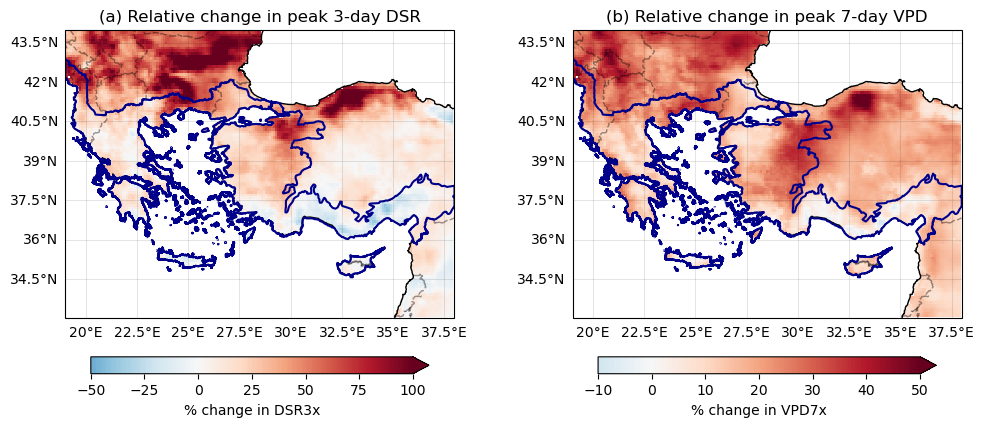

In [43]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,5), subplot_kw = {"projection" : mapproj, "extent" : (19,38,33,44)}, dpi = 100)

cbar_kwargs = {"location" : "bottom", "shrink" : 0.8, "pad" : 0.1}

dsr.dI_rel.plot(ax = axs[0], cmap = "RdBu_r", norm = MidpointNormalize(vmin = -50, midpoint = 0, vmax = 100), cbar_kwargs = cbar_kwargs | {"label" : "% change in DSR3x"})
axs[0].set_title("(a) Relative change in peak 3-day DSR")
vpd.dI_rel.plot(ax = axs[1], cmap = "RdBu_r", norm = MidpointNormalize(vmin = -10, midpoint = 0, vmax = 50), cbar_kwargs = cbar_kwargs | {"label" : "% change in VPD7x"})
axs[1].set_title("(b) Relative change in peak 7-day VPD")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.4)
    sf.boundary.plot(ax = ax, color = "darkblue")
    
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

plt.savefig("gridded-trend-maps.png")

/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


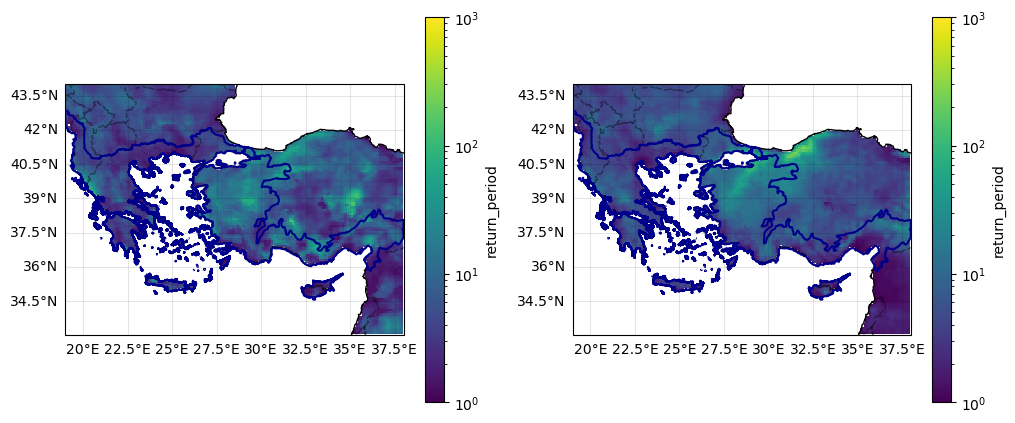

In [40]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,5), subplot_kw = {"projection" : mapproj, "extent" : (19,38,33,44)}, dpi = 100)

# axs[0].contourf(dsr.lon, dsr.lat, dsr.return_period, norm = colors.LogNorm(vmin = 1, vmax = 100))
# axs[1].contourf(vpd.lon, vpd.lat, vpd.return_period, norm = colors.LogNorm(vmin = 1, vmax = 100))

dsr.return_period.plot(ax = axs[0], norm = colors.LogNorm(vmin = 1, vmax = 1000))
vpd.return_period.plot(ax = axs[1], norm = colors.LogNorm(vmin = 1, vmax = 1000))

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.4)
    sf.boundary.plot(ax = ax, color = "darkblue")
    
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])